### TMA4320 - Project 2: Physics
### Group 1980

# 0.0 Motivasjon
I fysikk er vi interessert i å simulere fysiske systemer for å forutse hvordan disse vil oppføre seg. For enkle systemer kan vi benytte analytiske metoder i simulasjonene, men for større og mer avanserte er vi ofte nødt til å benytte oss av numeriske tilnærminger. I dette prosjektet skal vi studere en skipsmodell - Vasaskipet, og analysere hvordan dens bevegelse og stabilitet påvirkes av ulike krefter og faktorer. 

For å studere skipet vil vi trenge å løse ordinære differensiallikninger (ODE), og det er flere metoder - både analytiske og numeriske - å gjøre dette på. Vi vil benytte Eulers metode og fjerde ordens Runge-Kutta, som er to svært populære (Kjente? Eulers er vel egentlig ikke populær..?) numeriske metoder. Imens Runge-Kutta (RK4) er en fjerdeordens metode er Eulers metode kun av orden én, hvilket betyr at denne løsningen vil ha en lavere nøyaktighet. Vi vil studere forskjellen på disse to metodene og utforske i hvor stor grad valg av numerisk løsningsmetode påvirker resultatene i simulasjonen.

Til å begynne med vil vi jobbe mer en svært enkel simulasjon preget av mange forenklinger, og så vil vi gradvis utvide denne simulasjonen til å ta hensyn til flere og flere påvikningsfaktorer. Vår simulasjon vil på ingen måte ta hensyn til alle reelle faktorer som spiller en rolle i hvordan ekte båter beveger seg, men vil likevel gi et godt innblikk i mange av de sentrale faktorene som spiller inn.  

# 1.0 Skipsmodell

### 1.1 Skipets fysiske egeskaper
Istedet for å modellere skipet i tre dimensjoner er det hensiktsmessig å istedet se på et todimensjonalt snitt av skipet. Vår skipsmodell tar derfor utgangspunkt i et langt og halvsirkelformet skip med en radius R, som vugger om en akse i skipets lengderetning. Vi definerer skipets masse per flateenhet som $\sigma$ og masse per lengdeenhet som $\lambda$. I tilegg vil massesenteret ligge en lengde $h = 4R/3\pi$ under midtpunktet på dekket. 

Når skipet befinner seg i vann vil det fortrenge en mengde vann, hvor vi definerer mengden fortrengt vann som $A$. I likevekt kan vi beregne mengden fortrengt vann gjennom å beytte Arkimedes lov. 
$$
    m_{fortrengt vann} = A_0\sigma_{0} =  \frac{\sigma\pi R}{2} = m_{skip} \Rightarrow A_{0} = \frac{\sigma\pi R}{2\sigma_{0}}
$$
hvor $\sigma_{0} = 1000 kg/m^2$ er vannets massetetthet.

Dersom skipet begynner å vugge og ikke lengre befinner seg i likevekt vil mengden fortrengt vann ikke lengre være forbli konstant, noe som betyr at oppdriftskraften som virker på båden vil være i en konstant endring. For å beregne hvor mye vann som blir fortrengt kan vi benytte formelen 
$$
    A = \frac{1}{2}R^2(\gamma - sin\gamma)
$$
hvor $\gamma$ er sektorvinkelen og avhenger av rotasjonsvinkelen $\theta$ og den vertikale forflytningen i forhold til likevelt $\Delta y_{C} = y_{C} - y^0_{C}$. Sektorvinkelen kan beregnes ved å bruke den noe kompliserte formelen
$$
    \gamma = 2arccos(cos(\beta/2)-(4/3\pi)(1-cos\theta) + \Delta y_{C}/R)
$$  
hvor $\beta$ er sektorvinkelen ved likevekt og kan finnes ved å løse likningen 

\begin{equation}

   \beta - sin\beta = \pi\sigma/\sigma_{0}. \tag{1}
\end{equation}

En siste størrelse vi trenger når det kommer til beskrivelsen av selve skipet er dets treghetsmoment $I_{C}$ om tyngdepunktet $C$. Denne kan beregnes gjennom å bruke Steines sats
$$
    I_{C} = I_{M} - mh^2 = \frac{1}{2}mR^2(1-\frac{32}{9\pi^2})
$$

### 1.2 Ytre krefter
I våre beregninger skal vi ta hensyn til fire ulike ytre krefter. Gravitasjonskraften virker loddrett nedover og er gitt ved formelen $F_{G} = mg$. Oppdriftskraften er fra Arkimedes lov gitt som $F_{B} = \sigma_{0}Ag$ og virker loddrett oppover.

Når skipet er i bevegelse, f.eks gynger fra side til side, vil det virke friksjonskrefter mellom skipets skrog og vannet. En tilnærmelse av denne friksjonskraften $f$ er at den er propsjonal med størrelsen av skipets grenseflate mot vannet og vinkelhastigheten $\omega$. Denne grenseflaten vil for oss være gitt som $R\gamma$, hvor $\gamma$ er den samme som definert tidligere. Dette gir at friksjonskraften kan beskrives med formelen
$$
    f = -k_{f}R\gamma\omega
$$
hvor $k_{f}$ er vannets friksjonskoeffesient.

Den siste ytre krafta vi velger å inkludere er fra vind og bølger. Vi simulerer denne krafta som en harmonisk oscillerende kraft rettet horisontalt på tvers av lengderetningen, og som har angrepspunkt i samme høyde som vannlinja.
$$
    F_{w}(t) = F_{0}cos\omega_{m}t
$$


### 1.3 Bevegelig last
Vi skal etter hvert simulere at det befinner seg en bevegelig last på skipets dekk, og studere hvordan denne lasten påviker skipets dynamikk og stabilitet. Lasten simuleres som en punktmasse med masse $m_{L}$, og har en startposisjon hvor den ligger i ro i en posisjon $M$ midt på dekk. Dets posisjon $s_{L}$ spores relativt til midten av dekkes, og er positiv til høyre og negativ til venstre for midtpunket. Dette betyr blant annet at når $s_{L} = R$ befinner lasten seg helt til høyre på dekket og når $s_{L} = -R$ befinner den seg helt til venstre. For enkelhetens skyld ser vi bort fra alle friksjonskrefter og antar at lasten kun påvirkes av gravitasjonskraften og normalkraften. 

På grunn av lastens masse vil den virke med en kraft på skipet. Vi definerer denne kraften som $F_{L}$, og har kompnentene $F^x_{L} = m_{L}g cos\theta sin\theta$ og $F^y_{L} = -m_{L}g cos^2\theta$

I tillegg vil det på grunn av lastens bevegelse også virke et dreiemoment $\tau_{L}$ fra lasten. Denne er gitt som $\tau_{L} = -m_{L}g cos(\theta)s_{L}$.


# X.X Grunnlag fra mekanisk fysikk

For å beregne skipets bevegelse og hvordan det responderer på de ytre kreftene tar vi utgangspunkt i formler fra den mekaniske fysikken.

Ligingen som beskriver tyngdepunktbevegelsen er
$$
    \sum \vec{F} = m\vec{a} = m \frac{d\vec{v}}{dt} = m \frac{d^2\vec{r}}{dt^2}
$$
hvor vi benytter vektornotasjon ettersom vi har både en x- og en y-komponent.

I tillegg er rotasjonsbevegelsen gitt ved
$$
    \sum \tau = I_{C} \frac{d\omega}{dt}
$$
hvor dreiemomentets vektor alltid vil peke i z-retning i dette prosjektet.

Gjennom å løse disse to uttrykkene for $\frac{d\vec{v}}{dt}$ og $\frac{d\omega}{dt}$ kan vi finne uttrykk for det deriverte av farten og vinkelfarten. Dette vil være nytting når vi senere skal bruke numeriske metoder til å løse differensialligningene.

In [74]:
# Importing libraries
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import animation
from tempfile import TemporaryFile


# To show figures in the notebook
%matplotlib inline

# Make the figures more readable
newparams = {'figure.figsize': (18, 9), 'axes.grid': False,
             'lines.linewidth': 2,
             'font.size': 25, 'mathtext.fontset': 'stix',
             'font.family': 'STIXGeneral'}
# figure.figsize sets the size of the figure (values are in inches)
# axes.grid, set to False means that there is no grid
# lines.linewidth sets the thickness of the lines in the plot
# font.size sets the size of the text (ticks, title, xlabel, etc.)
# mathtext.fontset sets the font of the text of the type r'$tekst$' (math text)
# font.family sets the font of ordinary text (ticks, title, xlabel, etc.)

# There are several other parameters you can change, and you can look them up in the documentation 
# for matplotlib if you need to change any. 

plt.rcParams.update(newparams) # Updates the parameter set above. 

In [75]:
# Parameters
sigma_0 = 1000 # kg/m^2
sigma = 500 # kg/m^2
R = 10 # m, Radius
A_s = 0.5*np.pi*(R**2) # Cross-section of boat
A_0 = (sigma*np.pi*(R**2))/(2*sigma_0)
g = 9.81 # m/s^2
h = (4*R)/(3*np.pi)
m_boat = A_s*sigma

In [76]:
def calculate_I_c(m_load, s_L):
    '''
    This function calculated the ships total rotational inertia of the ship and its load, at the
    relative position of the load affects the total rotational inertia.
    Input:
        m_load: float, the mass of the load [kg]
        s_L:    float, the loads distance from the metacenter [m]
    Output:
        I_c:    float, the ships total rotational inertia [kg/m²]
    '''
    I_boat = 0.5*m_boat*(R**2)*(1-(32/(9*(np.pi**2)))) # Rotational inertia from the ship about C

    r_load = np.sqrt( h**2 + s_L**2 ) # Distance from ship's CM to load's CM
    I_load = m_load*r_load**2   # Rotational inertia from the load about C 
    
    I_c = I_load + I_boat # Use the superposition property of rotational inertias (Steiner's Thm).
    return I_c

## Sektorvinkelen

Når skipet er i likevekt, betegner vi sektorvinkelen $\beta$, den kan regnes ut fra fikspunktlikningen \begin{equation}

   \beta - sin\beta = \pi\sigma/\sigma_{0}. \tag{1}
\end{equation}

om nevnt tidligere. Ved bruk av newtons metode kan vi for eksempel bruke de fiktive parametrene $\sigma = 500kg/m^2$, $\sigma_0 = 1000kg/m^2$, regne ut at $\beta = 132.35\deg$. I newtons metode krever vi en startverdi som vi må gjette på, her velger vi x0 = 5, som konvergerer. (NEVN KONVERGENSTEOREMET MED DEN "BOKSEN"?)

In [77]:
def calculate_beta(rhs_constant, x0, tol=1.e-8, max_iter=50):
    ''' Given a right hand side and left hand side of a function and its derivatives, calculates the beta value of the function.
    
    Solve f(x)=0 by Newtons method, 
    
        The output of each iteration is printed
        Input:
        f_lhs: left hand side of function
        df_lhs: left hand side of derivative of function
        f_rhs: right hand side of function
        df_rhs: right hand side of derivative of function
        x0:  Initial values
        tol: The tolerance
      Output:
        The root and the number of iterations
    '''

    f = lambda beta: beta - np.sin(beta) - rhs_constant
    df = lambda beta: 1 - np.cos(beta)


    x = x0
    for k in range(max_iter):
        fx = f(x)
        if abs(fx) < tol:           # Accept the solution 
            break 
        x = x - fx/df(x)            # Newton-iteration
    return x

In [78]:
def print_beta():
    f_lhs = lambda beta: beta-np.sin(beta)
    df_lhs = lambda beta: 1 - np.cos(beta)

    f_rhs = lambda beta : np.pi * sigma/sigma_0
    df_rhs = 0

    beta = calculate_beta(np.pi*sigma/sigma_0,5)
    print("Beta = ",round(np.degrees(beta), 2),"degrees")
print_beta()

Beta =  132.35 degrees


## Diverse hjelpefunksjoner
Her definerer vi en del hjelpefunksjoner som vi får bruk for senere. Vi definerer y=0 til å være i vannflaten. Vi definerer metasenteret $y_M$, skipets massesenter $y_C$, skipets dypeste punkt $y_D$, og angrepspunktet til båten $y_B$. 

In [79]:
#Define the global variables for the equilibrium, as requested in 1b)
y_M_0 = lambda beta: R*np.cos(beta/2)
y_C_0 = lambda beta: y_M_0(beta) - 4*R/(3*np.pi)
y_B_0 = lambda beta: y_M_0(beta) - 4*R*(np.sin(beta/2))**3 /(3*(beta-np.sin(beta)))
y_D_0 = lambda beta: y_M_0(beta) - R

#Values as functions of delta y_C and theta. 
y_M = lambda beta, theta, delta_y_C : y_M_0(beta) + ((4*R)/(3*np.pi))*(np.cos(theta)-1) + delta_y_C
y_C = lambda beta,delta_y_c : y_C_0(beta) + delta_y_c
y_D = lambda beta, theta, delta_y_c : y_D_0(beta) + ((4*R)/(3*np.pi))*(np.cos(theta)-1) + delta_y_c
y_B = lambda beta: y_B_0(beta)

#Note: beta is a global variable
gamma = lambda beta, theta, delta_y_c : 2*np.arccos(np.cos(beta/2)-(4/(3*np.pi))*(1-np.cos(theta))+delta_y_c/R)

water_area = lambda gamma_number: 0.5*(R**2)*(gamma_number - np.sin(gamma_number))

F_G = lambda m : -m*g
F_B = lambda A : A*sigma_0*g
friction = lambda k_f, omega, gamma_number : -k_f * R * gamma_number*omega

## Oppvarming: Regning på forenklet system

Det er ofte nyttig å starte med en enda mer forenklet modell, før man øker kompleksiteten gradvis. I første omgang kommer vi til å neglisjere bevegelsen til skipets massesenter.

Vi ignorerer altså alle krefter utenom 

\begin{equation}
    F_G = -m g
\end{equation}

\begin{equation}

    F_B = A \sigma_0 g
\end{equation}

Vi antar også at $A = A_0$, det vil si at mengden fortrengt vann ikke endrer seg når skipet beveger seg, dette fører til at $\vert F_G\vert = \vert F_B\vert$, slik at det kun er dreiemomentet 

\begin{equation}
    \tau_B = -F_B h sin(\theta)
\end{equation}
som fører til bevegelse av skipet, da tyngdekraftens arm er lik 0, så det gir null dreiemoment.

Newtons andre lov gir følgende andreordens diffrensiallikning:
\begin{equation}
    \sum \tau = I_C \frac{d\omega}{dt} \rightarrow -F_B h sin(\theta) = I_C \ddot{\theta}
\end{equation}

For å numerisk løse den annenordens differensiallikningen introduserer vi vektoren $\vec{\omega}(t) = \begin{bmatrix} \theta(t) & \omega(t) \end{bmatrix}^T$. Gjennom å benytte denne deler vi vår annenordens differensiallikning opp i to førsteordens differensiallikninger. Vi kan skrive den deriverte av $\vec{\omega}(t)$ som
$$
    \frac{d\vec{\omega}}{dt} = \begin{bmatrix} \frac{d\theta}{dt} & \frac{d\omega}{dt} \end{bmatrix}^T = \vec{f}(t, \vec{\omega})
$$

For å finne et uttrykk for $\vec{f}(t, \vec{\omega})$ benytter vi at $\frac{d\theta}{dt} = \omega$. I tillegg kan vi finne $\frac{d\omega}{dt}$ gjennom formelen for skipets rotasjonsbegegelse, hvor vi antar at det kun er dreiemomentet $\tau_{B}$ som påvirker hvordan skipet beveger seg.
$$
    \sum \tau = I_{C}\frac{d\omega}{dt} \Rightarrow \frac{d\omega}{dt} = \frac{ \sum \tau}{I_{C}} = \frac{\tau_{B}}{I_{C}} = -\frac{F_{B}h}{I_{C}}\sin\theta = -\frac{A\sigma_{0}gh}{I_{C}}\sin\theta
$$

Dette gir oss et uttrykket
$$
    \frac{d\vec{\omega}}{dt} = \vec{f}(t, \vec{\omega}) =  \begin{bmatrix} \omega(t) & -\frac{A\sigma_{0}gh}{I_{C}}\sin(\theta(t)) \end{bmatrix}^T 
$$

# 1.3 Eulers metode

Eulers metode er en førsteordens metode for å løse ODE'er med gitte initialverdier, og er den mest grunnleggende metoden vi kan benytte for å løse vår differensiallikning. Ettersom det er en førsteordens metode medfører dette en høy feil sammenliknet med andre metoder. Vi har at det at den lokale feilen er proposjonal med kvadratet av steglengden, og den globale feilen er propsjonal med steglengden.

Vår ODE $\frac{d\vec{\omega}}{dt} = \vec{f}(t, \vec{\omega})$ kan ved bruk av Eulers metode løses ved å bruke formelen
$$
    \vec{\omega}_{i+1} = \vec{\omega}_{i} + h\vec{f}(t_{i}, \vec{\omega}_{i})
$$

hvor h er steglengden (avstanden mellom t-verdiene). Dersom vi kjenner en initialverdi $\vec{\omega}(t = t_{0})$ kan vi dermed tilnærme hva $\vec{\omega}(t)$ vil være ved andre tidspunkt.

Vi definerer først en funksjon euler_step som returnerer den neste verdien av t og w, gitt en funksjon f, steglenge h, og tidligere verdier av t og f.

In [80]:
def euler_step(f, t, w, h_step):
    '''
    Tar inn en vektor-funksjon på formen w = [theta(t), omega(t)], med nåværende tid (t) og 
    tilstand (w), og regner ut ett Euler-steg.
    Inn:
        f: s-array, som beskriver et system av førsteordens diff-ligninger.
        t: float, nåvernde tid
        w: s-array, som beskriver systemet
        h_step: steglengde
    Ut:
        t_new: neste tidssteg (t+h)
        w_new: systemet etter ett beregnet tidssteg    
    '''
    
    w_new = w + h_step*f(t, w)
    return t+h, w_new

Ettersom Eulers metode har flere kjente svakheter, lager så en generell ODE løser som tar inn parameteren method, slik at vi kan velge mere robuste step-funksjoner på et senere tidspunkt. Vi legger også inn muligheter adaptiv steglengde.

In [81]:
def solve_ODE(f, t_0, t_end, w_0, h_0, method, fixed_step = True, tol = 1e-6, max_iter = 1e5):
    '''
    Funksjon som løser differensial ligninger på en brukerdefinert måte.
    Inn:
        f: s-array, som beskriver et system av førsteordens diff-ligninger.
        t_0: float, starttid
        t_end: float, slittid
        w_0: s-array, som systemets startposisjon
        h_0: Dersom vi ønsker dynamisk steglengde vil dette være startsteglengden
            ellers blir dette den konstante steglengden
        tol: The tollerance if we wish to use adaptive step size
    Ut:
        t_num: array, tidsstegene
        w_num: s-array, de beregnede verdiene for theta of omega    
    '''
    t_num = np.array([t_0])
    w_num = w_0
    # Set the running values
    t_n = t_0
    w_i = w_0
    h_step = h_0
    

    if fixed_step:
        N = int( (t_end-t_0)/h_step + 1)
        t_num, h_step = np.linspace(t_0, t_end, N, retstep=True)  # Use linpace, as numpys documentation suggests this for
                                            # non-integer values, we also get the closed interval [t_0, t_end].
        # print(f't_num:\n {t_num}\n t_num minus one:\n {t_num[0:-1]}')        

        # This loop will iterate over all the t-values exept the last one. The reason for this is because the w corresponding
        # to the last t-value is calculated at the second last t-value, and so, both arrays have an equal lenght.
        for t_n in t_num[0:-1]: 
            w_i = method(f, t_n, w_i, h_step)[1] # Here we are only interrested in w, as the step size is fixed
            #print(f'w_num:\n {w_num}\n\n w_{i+1}:\n {w_n}\n\n\n\n ')
            w_num = np.concatenate(( w_num, w_i), axis=1)

    else: 
        current_iter = 0
        while t_n < t_end-1e-10: # take truncation error into account        
            if t_n + h_step > t_end:
                h_step = t_end-t_n
                
            # One step with the method:
            t_try, w_try, err_est, p = method(f, t_n, w_n, h_step)
            current_f_calls += 1
            
            if err_est <= tol:
                # Use the solution
                t_n = t_try
                w_n = w_try
                
                # Store the solutions
                t_num = np.append(t_num, t_n)           
                w_num = np.concatenate((w_num, np.array([w_n])))
                
            
            # Adjust the step size, start by defining facors
            P = 0.8 # Pessismist facor, normally between 0.5 and 0.95
            
            h_step = P*( (tol/err_est)**(1/(p+1)) )*h_step

            if current_iter >= max_iter:
                print('Maximum number of function calls are reached.')
                return t_num, w_num

    
    
    
    return t_num, w_num

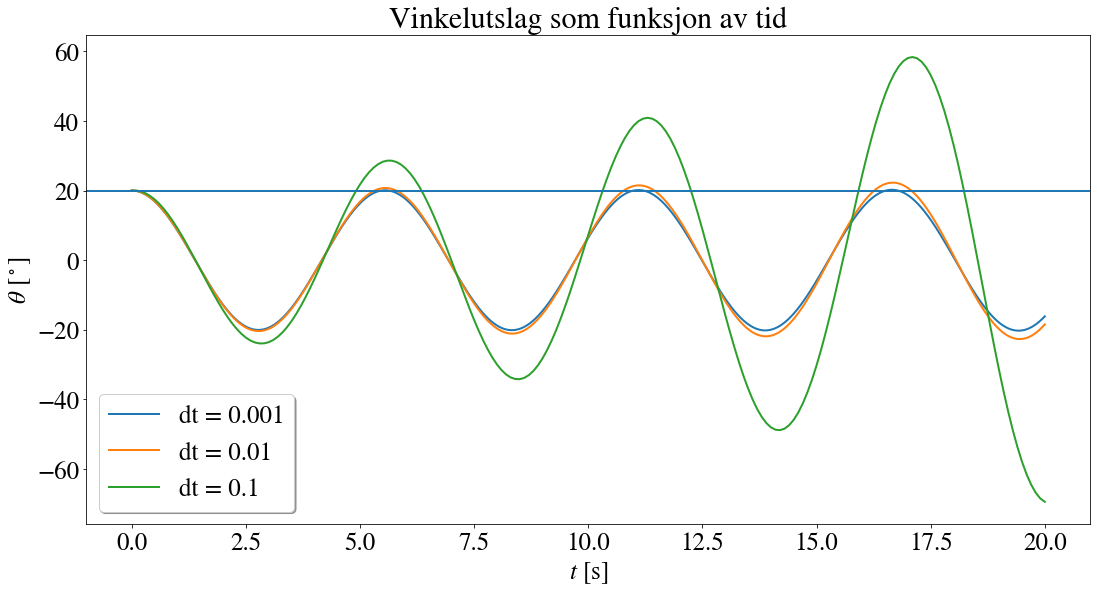

In [82]:
def test_euler():
    # f = lambda t, w: np.array([
    #     w[1],
    #     -(A_0 * sigma_0 * g * h)/calculate_I_c(0, 0) * np.sin( w[0] )
    #     ])
    
    # This function is equivalent
    def f(t, w):
        dw = np.array([
            w[1],
            -(A_0 * sigma_0 * g * h)/calculate_I_c(0, 0) * np.sin( w[0] )
        ])
        return dw

    # Define the inital condititons, time intervall, and step size
    theta_0 = np.array([np.radians(20)])
    omega_0 = np.array([0])
    w_0 = np.array([theta_0, omega_0]) # Combine all the initial conditions to the array w

    t_0 = 0
    t_end = 20

    h_step1 = 0.001  #The step size of our simulation
    h_step2 = 0.01
    h_step3 = 0.1


    # Calculate the angles and angle velocities in the given time intervall using the Euler method
    t_num1, w_num1 = solve_ODE(f, t_0, t_end, w_0, h_step1, euler_step)
    t_num2, w_num2 = solve_ODE(f, t_0, t_end, w_0, h_step2, euler_step)
    t_num3, w_num3 = solve_ODE(f, t_0, t_end, w_0, h_step3, euler_step)


    theta_num1, omega_num = w_num1[0:2]
    theta_num2, omega_num = w_num2[0:2]
    theta_num3, omega_num = w_num3[0:2]


    

    # Plot the angles vs time
    plt.plot(t_num1, np.rad2deg(theta_num1), label = "dt = 0.001")
    plt.plot(t_num2, np.rad2deg(theta_num2), label = "dt = 0.01")
    plt.plot(t_num3, np.rad2deg(theta_num3), label = "dt = 0.1")
    plt.axhline(20)
    plt.title("Vinkelutslag som funksjon av tid")
    plt.xlabel('$t$ [s]')           
    plt.ylabel(r'$\theta$ [$^\circ$]')   
    # plt.ylim(-0.4,0.4)        
    plt.legend(loc=3, shadow = True)
    plt.show()

test_euler()

Her illustreres et av problemene med Eulers metode: amplituden øker for hver periode, og dette gir ikke fysisk mening når systemet vårt kun har med tyngekraft og oppdrift. Dette fenomenet vil oppstå uansett hvor lav steglende man bruker, det vil bare ta lenger tid

En steglengde på h=0.001 gir gode resultater for vårt tidsintervall, samtidig som kjøretiden er veldig rask. Vi ser på plottet under at dette ligner på en harmonisk oscillator, som virker fornuftig gitt våre forenklinger av systemet. Ettersom det kun er tyngdekraft og oppdrift som har en effekt, kan man tenke at momentet fra oppdriften alltid vil virke i motsatt retning av utslagsvinkelen $\theta$, og ettersom alle friksjonskrefter er idealisert bort, vil den aldri stoppe opp, så da blir det åpenbart en harmonisk oscillator.



Dersom vi bruker liten nok steglengde, kombinert med en begrenset tidshorisont, har vi en ODE-løser som er brukbar. Vi tar derfor en liten avstikker for å analysere en av fysikkens mest brukte approksimasjoner, nemlig $sin(\theta) \approx \theta$. 

Hvis vi ser på diffligningen i oppgaven over, med denne approksimasjonen, får vi
\begin{equation}
    -mgh \theta = I_C \ddot{\theta}
\end{equation}
der $F_B =A\sigma_0 g = mg$ da vi har antatt konstant $A$.

Denne difflikningen kan løses numerisk med samme metode som over, og vi kan sammenligne verdiene.


(Her må vi plotte både ved 1 og 20 grader, så her burde vi kanskje bruke den nye plottefunksjonen..?)

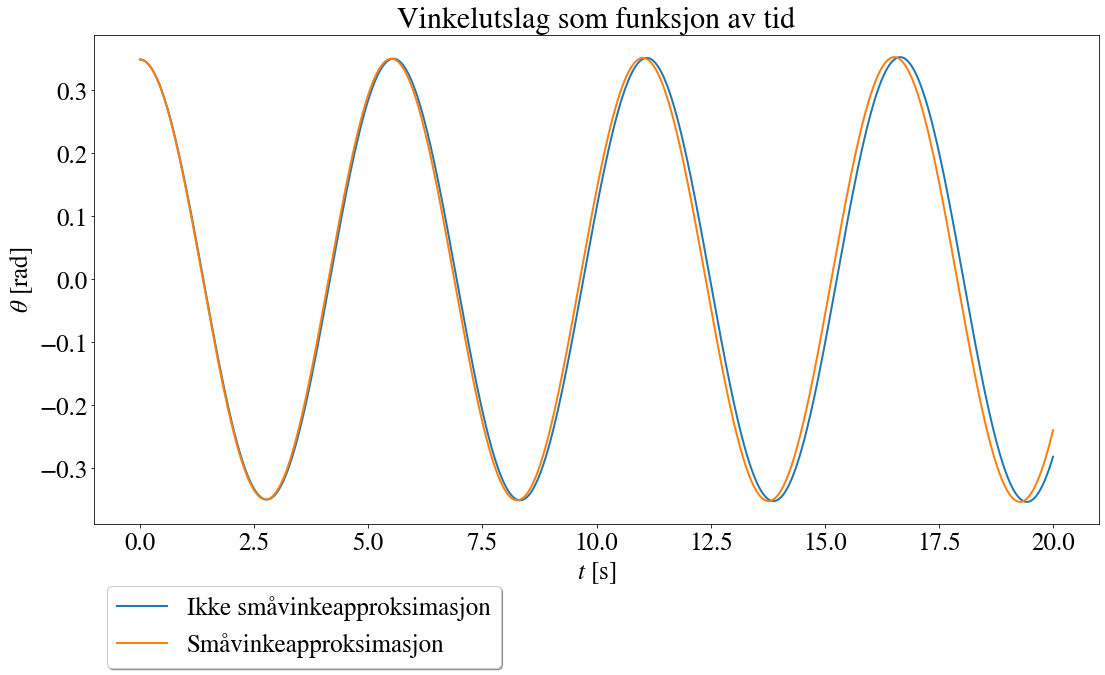

In [83]:
def angle_approx_comparison():
    # def f(t, w):
    #     const = (A_s*sigma * g * h)/calculate_I_c(0, 0)
    #     return np.array([w[1], -const*np.sin(w[0]),0,0,0,0,0,0])

    # def f_small_angle(t, w):
    #     const = (A_s*sigma * g * h)/calculate_I_c(0, 0)
    #     return np.array([w[1], -const*w[0],0,0,0,0,0,0])

    #######################################################################################
    #       Define the functions differential equations that we will be solving
    f = lambda t, w: np.array([
        w[1],
        -(A_s*sigma * g * h)/calculate_I_c(0, 0) * np.sin(w[0])
    ])
    f_small_angle = lambda t, w: np.array([
        w[1],
        -(A_s*sigma * g * h)/calculate_I_c(0, 0) * w[0]
    ])

    #######################################################################################
    #       Define the inital condititons, time intervall, and step size
    theta_0 = np.array([np.radians(20)])
    omega_0 = np.array([0])
    w_0 = np.array([theta_0, omega_0]) # Combine all the initial conditions to the array w

    t_0 = 0
    t_end = 20

    h_step = 0.001  #The step size of our simulation
    #######################################################################################
    #       Solve diff. eqn. by the given methods, and 
    t_num, w_num = solve_ODE(f, t_0, t_end, w_0, h_step, euler_step)
    t_num_small_angle_approx, w_num_small_angle_approx = solve_ODE(f_small_angle, t_0, t_end, w_0, h_step,euler_step)

    
    theta_num, omega_num = w_num[0:2] #Hvordan funker det her egt? 
    # print(theta_num)
    # theta_num = w_num[0]
    # print(theta_num)
    theta_num_small_angle_approx, omega_num_small_angle_approx = w_num_small_angle_approx[0:2]
    # theta_num_small_angle_approx[0]


    diff = theta_num_small_angle_approx - theta_num    


    plt.plot(t_num, theta_num, label = "Ikke småvinkeapproksimasjon")
    plt.plot(t_num_small_angle_approx, theta_num_small_angle_approx, label = "Småvinkeapproksimasjon")
    # plt.plot(t_num, diff, label = "Differanse")
    plt.title("Vinkelutslag som funksjon av tid")
    plt.xlabel('$t$ [s]')           
    plt.ylabel(r'$\theta$ [rad]')   
    # plt.ylim(-0.2,0.2)        
    plt.legend( 
        bbox_to_anchor=(0,-0.1),
        loc='upper left',
        shadow = True
        )
    plt.show()

angle_approx_comparison()

Vi ser at for $\theta = 1\deg$ er plottene praktisk talt identiske. For $\theta = 20\deg$ er det en synlig forskjell, men fortsatt en dugelig approksimasjon i tilfeller der ekstrem nøyaktighet ikke er vesentlig. Så totalt sett er det en veldig nyttig approksimasjon.

Vi velger nå å implementere en litt mer robust ODE-løser, nemlig den klassiske Runge-Kutta metoden. Denne vil nemlig ikke ha samme problemet som Eulers metode med håndtering av amplitudene.

In [84]:
def rk4_step(f, t, w, h):
    '''
    Tar inn en vektor-funksjon på formen f(t, _w_) = _y'_ = _y_ + _g(x)_, med nåværende tid (t) og 
    tilstand (w), og regner ut ett Runge Kutta steg.
    Inn:
        f: s-array, som beskriver et system av førsteordens diff-ligninger.
        t: float, nåvernde tid
        w: s-array, som beskriver systemet
    Ut:
        t_new: neste tidssteg (t+h)
        w_new: systemet etter ett beregnet tidssteg    
    '''

    k_1 = f(t, w)
    k_2 = f(t + 0.5*h, w + h*k_1*0.5)
    k_3 = f(t + 0.5*h, w + h*k_2*0.5)
    k_4 = f(t + 1.0*h, w + h*k_3)

    w_new = w + h*(1/6) * (k_1 + 2*k_2 + 2*k_3 + k_4)
    t_new = t + h
    
    return t_new, w_new

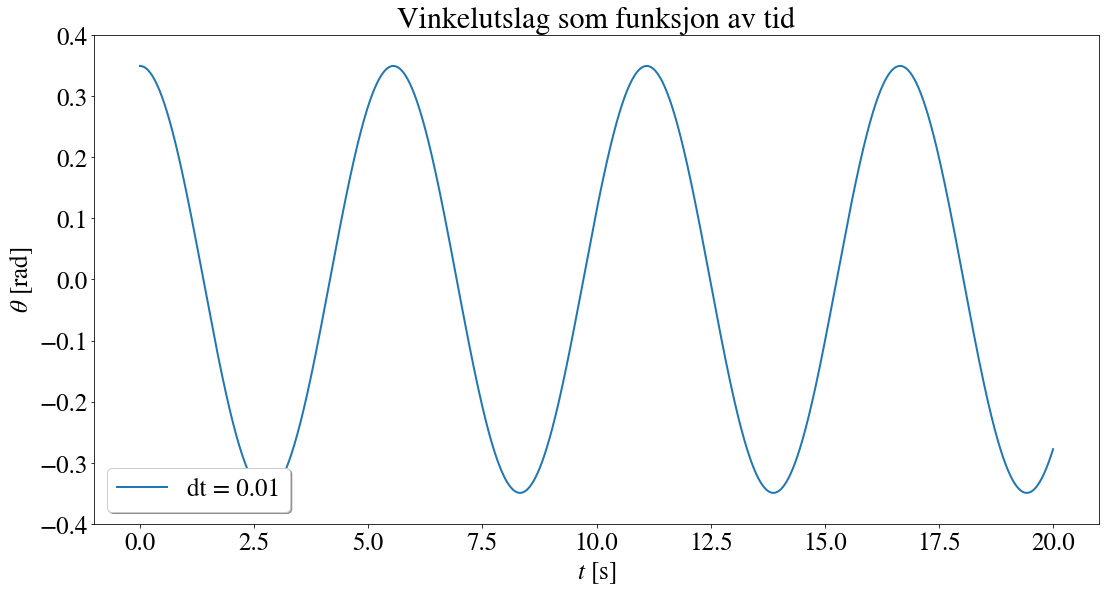

In [85]:
def test_runge_kutta():

    # def f(t, w):
    #     const = (A_s*sigma * g * h)/calculate_I_c(0, 0)
    #     return np.array([w[1], -const*np.sin(w[0]),0,0,0,0,0,0])
    
    #######################################################################################
    #       Define the functions differential equations that we will be solving
    f = lambda t, w: np.array([
        w[1],
        -(A_0 * sigma_0 * g * h)/calculate_I_c(0, 0) * np.sin( w[0] )
        ])


    #######################################################################################
    #       Define the inital condititons, time intervall, and step size
    theta_0 = np.array([np.radians(20)])
    omega_0 = np.array([0])
    w_0 = np.array([theta_0, omega_0]) # Combine all the initial conditions to the array w

    t_0 = 0
    t_end = 20

    h_step = 0.01  #The step size of our simulation
    #######################################################################################

    t_num_rk4, w_num_rk4 = solve_ODE(f, t_0, t_end, w_0, h_step, rk4_step)
    theta_num_rk4, omega_num_rk = w_num_rk4[0:2]


    plt.plot(t_num_rk4, theta_num_rk4, label = "dt = 0.01")
    plt.title("Vinkelutslag som funksjon av tid")
    plt.xlabel('$t$ [s]')           
    plt.ylabel(r'$\theta$ [rad]')   
    plt.ylim(-0.4,0.4)        
    plt.legend(loc=3, shadow = True)
    plt.show()
    
test_runge_kutta()

Differensiallikningen vi fikk ved å bruke småvinkelapproksimasjonen 
\begin{equation} 
-mgh \theta = I_C \ddot{\theta} 
\end{equation} 
kan fint løses analytisk som vi gjorde tidligere, men den har også en analytisk løsning, nemlig en harmonisk oscillator av formen 

\begin{equation}
    f(\theta) = \theta_0 cos(\sqrt{\frac{m_{boat} g h }{I_c}}\cdot t)
    
\end{equation}

Dette kan vi bruke som sammenligningsgrunnlag for å vurdere feilen til henholdsvis Euler og Runge Kutta-metodene, for diverse steglengder. Vi velger her å bruke logaritmisk akse på både x og y aksen når vi plotter, da vi beveger oss over flere størrelsesordener. Til dette bruker vi en logaritmisk linspace som utgangspunkt for å velge h-verdier.

In [86]:
def anal_vs_num():
    #######################################################################################
    #       Define the functions differential equations that we will be solving
    def f_analytic(t, theta_0):
        return theta_0*np.cos( np.sqrt( (m_boat*g*h)/calculate_I_c(0, 0) )*t )
    
    # To be used in numerical solutions
    f_small_angle = lambda t, w: np.array([
        w[1],
        -(A_0 * sigma_0 * g * h)/calculate_I_c(0, 0) * w[0]
        ])
    f_not_small_angle = lambda t, w: np.array([
        w[1],
        -(A_0 * sigma_0 * g * h)/calculate_I_c(0, 0) * np.sin( w[0] )
        ])
    
    # def f_small_angle(t, w):
    #     const = (A_s*sigma * g * h)/calculate_I_c(0, 0)
    #     return np.array([w[1], -const*w[0],0,0,0,0,0,0])
    # def f_not_small_angle(t, w):
    #     const = (A_s*sigma * g * h)/calculate_I_c(0, 0)
    #     return np.array([w[1], -const*  np.sin(w[0]),0,0,0,0,0,0])


    # theta_0 = np.radians(0.01)
    # omega_0 = 0
    # w_0 = np.array([theta_0, omega_0,0,0,0,0,0,0])

    # t_0 = 0
    # t_end = 20


    #######################################################################################
    #       Define the inital condititons, time intervall, the array of step sizes, 
    #       and the analytic value at t=20s
    theta_0 = np.array([0.01])
    omega_0 = np.array([0])
    w_0 = np.array([
        theta_0, 
        omega_0
    ]) # Combine all the initial conditions to the array w

    t_0 = 0
    t_end = 20

    h_steps = 10**np.linspace(-4, -1, 30) #logaritmic linspace


    #######################################################################################
    #       Find the values of different methods (including analytic) at t=20s
    #       using different step sizes
    f_analytic_t_20 = f_analytic(t_end, theta_0) # Analytic value at t=20s

    theta_t20_arr_euler = np.array([])
    theta_t20_arr_rk4 = np.array([])

    # Iterate through all the desired step sizes, and store them
    for h_step in h_steps:
        theta_euler    =   solve_ODE(f_small_angle, t_0, t_end, w_0, h_step, euler_step)[1][0] #[1]: w, [0]: theta
        theta_rk4      =   solve_ODE(f_small_angle, t_0, t_end, w_0, h_step, rk4_step)[1][0]
        
        # t_euler, theta_euler = solve_ODE(f_small_angle, t_0, t_end, w_0, h_step, euler_step) #[1]: w, [0]: theta)
        # t_rk4, theta_rk4 = solve_ODE(f_small_angle, t_0, t_end, w_0, h_step, euler_step) #[1]: w, [0]: theta)
        # print(f'last euler t: {t_euler[-1]}')
        # print(f'last rk4 t: {t_rk4[-1]}')

        # Store the angle at t=20s (the last angle)
        theta_t20_arr_euler =   np.append(theta_t20_arr_euler, theta_euler[-1])
        theta_t20_arr_rk4   =   np.append(theta_t20_arr_rk4 , theta_rk4[-1])


    difference_euler    = theta_t20_arr_euler   -   f_analytic_t_20
    difference_rk4      = theta_t20_arr_rk4     -   f_analytic_t_20
    # difference_rk4 = np.abs(difference_rk4)
    
    #######################################################################################
    #       Save the data to a file
    np.savez(
        'simulation_data/difference_at_t20',
        h_steps = h_steps,
        difference_euler = difference_euler,
        difference_rk4 = difference_rk4
        
        )
#anal_vs_num()

Ettersom denne funksjonen hadde en kjøretid på ca 2 minutter, valgte vi å lagre dataene for senere bruk.

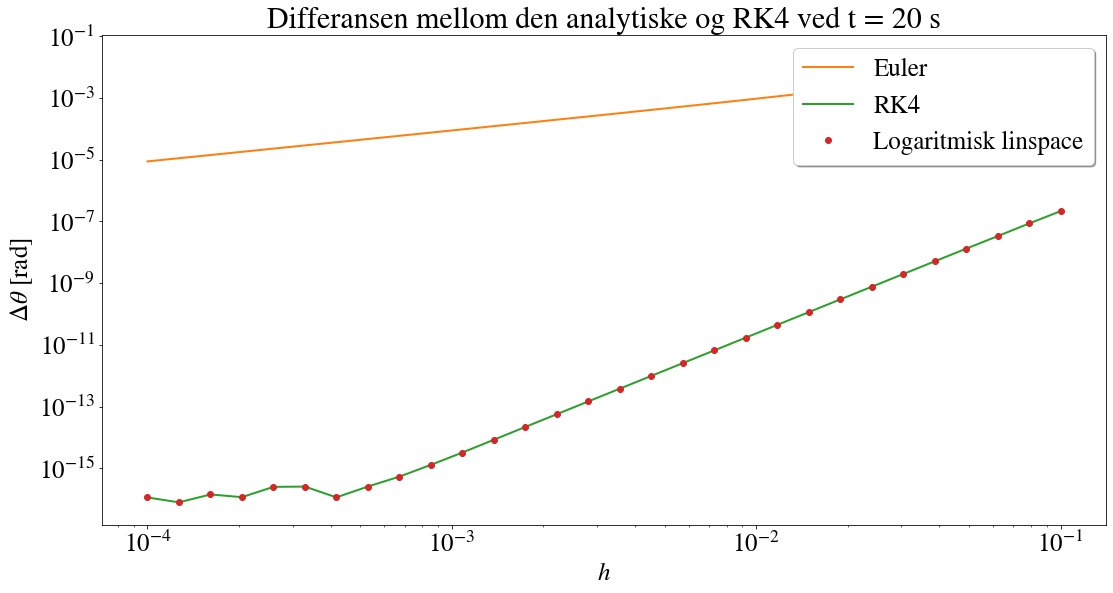

In [87]:
#######################################################################################
#       Plot the differences
def plot_difference():
    
    diff_data = np.load('simulation_data/difference_at_t20.npz')
    h_steps, difference_euler, difference_rk4 = diff_data['h_steps'], diff_data['difference_euler'], diff_data['difference_rk4']

    plt.yscale("log")
    plt.xscale("log")
    plt.plot(h_steps, np.zeros(len(h_steps)),linestyle='--') # Stiplet linje i 0
    plt.plot(h_steps, np.abs(difference_euler), label = "Euler")
    plt.plot(h_steps, np.abs(difference_rk4), label = "RK4")
    plt.plot(h_steps, np.abs(difference_rk4),'o', label = "Logaritmisk linspace")

    plt.title("Differansen mellom den analytiske og RK4 ved t = 20 s")
    plt.xlabel('$h$')           
    plt.ylabel(r'$\Delta\theta$ [rad]')   
    #plt.ylim(-0.2,0.2)        
    plt.legend(loc=1, shadow = True)
    # plt.axvline(10e-3)
    # plt.axvline(10e-4)
    # plt.axhline(10**-(14.5))
    # plt.axhline(10**-10.5)

    # plt.axhline(10**-(3))
    # plt.axhline(10**-4.1)
    # plt.show()
    # print("euler: ",(10**-3 - 10**-4.1)/10 )
    # print("rk4: ", (10**-10.5 - 10**-14.5)/10)


    # plt.yscale("log")
    # plt.plot(h_steps, np.zeros(len(h_steps)),linestyle='--') # Stiplet linje i 0
    # plt.plot(h_steps, difference_euler, label = "Euler")
    # plt.plot(h_steps, difference_rk4, label = "RK4")

    # plt.title("Differansen mellom den analytiske og RK4 ved t = 20 s")
    # plt.xlabel('$h$')           
    # plt.ylabel(r'$\Delta\theta$ [rad]')

    # plt.legend(loc=2, shadow = True)
    # plt.show()

plot_difference()

Vi ser at Runge-Kutta metoden er vesentlig bedere for alle steglengder. 

Begge funksjonene får åpenbart en lavere feil når vi reduserer steglengden, men vi ser at når vi nærmer oss $10^-16$ så er det ikke lenger noe forbedring å hente fra reduksjon av steglengde. Dette er ikke spesifikt til RK4, det er rett og slett fordi vi har nått maskinpresisjonen for floats på et 32 bit system. Dette kan man enkelt se ved hjelp av kodelinjen under, der man trekker fra hverandre tall slik at vi forventer at svaret blir null, eller evt bruke numpy sin funksjon

Hvis vi ser på området som ikke er påvirket av maskinpresisjon, ser vi at Runge-Kutta metoden for en gitt endring i steglengde vil få en større reduksjon. Denne økningen er på plottet vårt ca 2.5 ganger så stort. (FORVENTET VI DETTE..? Jeg så for meg en større økning.. første orden vs fjerde orden)

In [88]:
print("Maskinpresisjon: ",7./3 - 4./3 -1)
print("Numpy funksjon" ,np.finfo(float).eps)

Maskinpresisjon:  2.220446049250313e-16
Numpy funksjon 2.220446049250313e-16


In [89]:
def check_capsizing(w_num):
    '''
    Checks if the boat is capsizing. 
    Input:
    w_num: array with all the physical properties of the boat
    output:
    w_num: Same array, but now updated values if the boat has capsized.
    
    '''
    beta = calculate_beta(np.pi*sigma/sigma_0, 5) # Guess 5 for initial beta

    theta_arr = w_num[0]
    y_arr = w_num[3]
    for i in range(len(theta_arr)-1):
        theta_n = theta_arr[i]
        delta_y_n= y_arr[i+1]-y_arr[i]
        delta_y_c_n = y_C(beta,delta_y_n)
        if theta_n > 0.5*(np.pi-gamma(beta,theta_n,delta_y_c_n,)): #Sjekk om båten kantrer
           
            theta_arr[i+1] = np.pi/2 * np.sign(theta_arr[i])
           
            for j in range(1,(len(w_num))):
                w_num[j][i+1]=0
            
    return w_num


In [90]:
def universal_func(w_start_vals, t_end_input, h_step_input, F_0, k_f, omega_w_input, m_boat_input, m_L_input):
    '''
    Universell funksjon som kan benyttes til å beregne bevegelsen til skipet for mange ulike tilfelle.
    Gjennom hva man skriver i funksjonens argument kan man bla. simulere påvikningen friksjon, bølger og last.
    Inn:
        w_start_vals: s-array, inneholder alle startverdier 
            w_start_vals = [theta_0, omega_0, x_C_0, y_C_0, v_x_0, v_y_0, s_L_0, v_L_0]
        t_end_input: float, sluttid til simulasjonen
        h_step_input: float, steglengde til simulasjonen
        F_0: float, amplitiden til den harmoniske funksjonen som beskriver vind/bølger
        k_f: float, friksjonskoeffesient
        omega_w_input: float, vinkelfrekvensen til den harmoniske funksjonen som beskriver vind/bølger
        m_boat_input: float, massen til båten
        m_L_input: float, massen til lasten
    Ut:
        t_num: array, tidsverdier
        w_num: array, w som inneholder alle beregnede verdier
    '''
    
    
    # Sector-angle in equilibrium
    beta_step = calculate_beta((np.pi*sigma*(R**2)+2*m_L)/(sigma_0*(R**2)), 5) # Guess 5 for initial beta
    m_tot = m_boat + m_L
    
    # Equating the moment of intertia
    I_C = calculate_I_c(0, 0)
    
    def f(t, w):  
        '''
        Funksjon som brukes til å regne ut endringen til systemet.
        Inn:
            t: float, tid
            w: s-array, beskriver diverse av systemets fysiske egenskaper
        Ut:
            dw: endringen i w i det neste tidssteget
        
        '''
        # Vertical displacement
        delta_y_C_step = w[3] - y_C_0(beta_step) 
        
        # Sector-angle
        gamma_step = 2*np.arccos(np.cos(beta_step/2) - (4/(3*np.pi))*(1-np.cos(w[0])) + delta_y_C_step/R)
       
        # Repressed water
        A_step = water_area(gamma_step)
        
        # Gravitation and bouancy
        F_G_step = F_G(m_boat)
        F_B_step = F_B(A_step)
        
        # Friction and wind/waves
        F_w_step = F_0*np.cos(t*omega_w)
        F_f_step = friction(k_f, w[1], gamma_step)
        
        # The components of the contact-force between the load and the ship
        F_L_x_step = m_L*g*np.cos(w[0])*np.sin(w[0])
        F_L_y_step = -m_L*g*(np.cos(w[0])**2)
 
        # Torque 
        tau_B_step = -F_B_step*h*np.sin(w[0])
        tau_f_step = F_f_step*(w[3] - (R*(np.cos(gamma_step/2)-1)))
        tau_w_step = F_w_step*w[3]
        tau_L_step = -m_L*g*np.cos(w[0])*w[6]
    
        # Equate valier for the derivative of the w-vector, and combining them in an array
        d_theta = w[1]
        d_omega = (1/I_C)*(tau_B_step + tau_f_step + tau_w_step + tau_L_step)
        d_x     = w[4]
        d_y     = w[5]
        d_v_x   = (1/m_tot)*(F_f_step + F_w_step + F_L_x_step)
        d_v_y   = (1/m_tot)*(F_G_step + F_B_step + F_L_y_step)
        d_s_L = w[7]
        d_v_L = g*np.sin(w[0])
        
        dw = np.array([
            d_theta,
            d_omega,
            d_x,
            d_y,   
            d_v_x,  
            d_v_y, 
            d_s_L,
            d_v_L
        ])
        
        return dw

    # Initsialverdier
    theta_0 = np.array([np.radians(w_start_vals[0])])
    omega_0 = np.array([w_start_vals[1]])
    x_C_0 = np.array([w_start_vals[2]])
    
    # Tenk ut en god løsning på dette. 
    initial_y_C = np.array([y_C_0(beta_step)])
    #initial_y_C = np.array([w_start_vals[3]])
    
    v_x_0 = np.array([w_start_vals[4]])
    v_y_0 = np.array([w_start_vals[5]])
    s_L_0 = np.array([w_start_vals[6]])
    v_L_0 = np.array([w_start_vals[7]])

    w_0 = np.array([
        theta_0, 
        omega_0, 
        x_C_0, 
        initial_y_C, 
        v_x_0, 
        v_y_0, 
        s_L_0, 
        v_L_0
    ])

    t_0 = 0
    t_num, w_num = solve_ODE(f, t_0, t_end_input, w_0, h_step_input, rk4_step)
    w_num = check_capsizing(w_num)
    return t_num, w_num

In [91]:
def plot_func(t_num_arr, values_2d_arr, label_arr, title_name, x_axis_name, y_axis_name):
    for i in range(len(values_2d_arr)):
        plt.plot(t_num_arr, values_2d_arr[i], label = label_arr[i])
    plt.title(title_name)
    plt.xlabel(x_axis_name)           
    plt.ylabel(y_axis_name)   
    # plt.ylim(-0.25,0.25)        
    plt.legend(loc=3, shadow = True)
    plt.show()

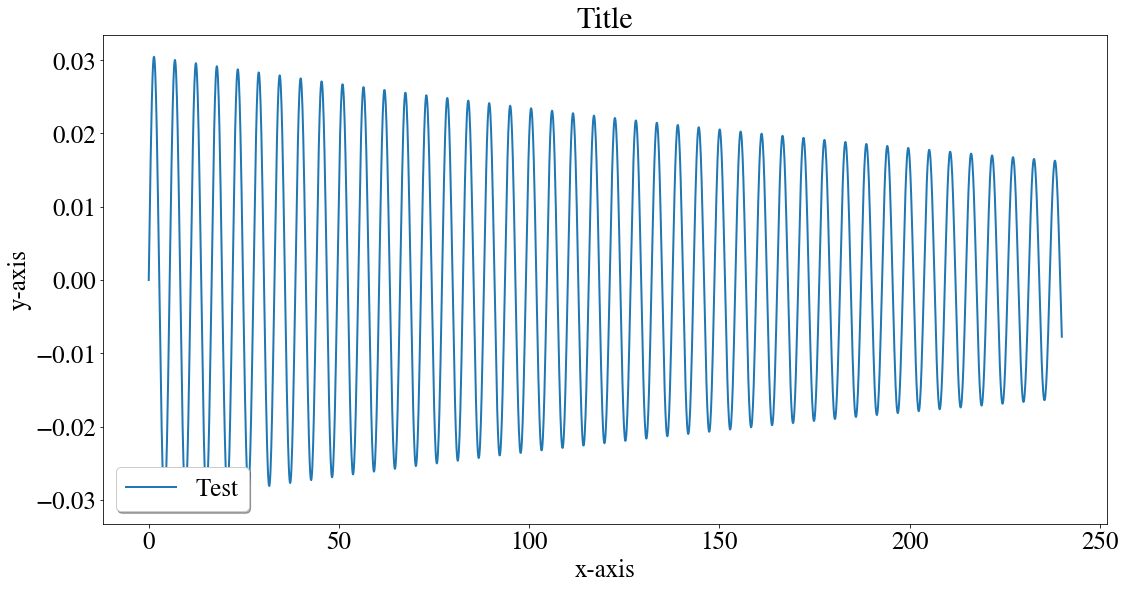

In [92]:
w_start_vals = [0, np.radians(2), 0, 0, 0, 0, 0, 0]

#F_0 = 0.625*m_boat*g
F_0 = 0
k_f = 100
t_end = 240
h_step = 0.1

omega_0 = np.sqrt((m_boat*g*h)/calculate_I_c(0, 0))
omega_w = 0.93*omega_0

m_boat = A_s*sigma
m_L = 0

t_num, w_num = universal_func(w_start_vals, t_end, h_step, F_0, k_f, omega_w, m_boat, m_L)

theta_num = w_num[0]
plot_func(t_num, [theta_num], ["Test"], "Title", "x-axis", "y-axis")